In [1]:
# build a dataframe 

import pandas as pd

df = pd.read_csv("/Users/orioldiaz/Downloads/counterfactual_appnexus_no_gmb_raw_longer.csv")

In [2]:
df.tail(2)

,date,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,smart bCPMM,sovrn bCPMM,sovrnxsp bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,ic03_dsps_bcpmm
83,23/11/2024,24.1,215.1,65.5,257.0,172.5,9.3,323.8,433.7,87.9,...,104.7,84.4,17.3,183.2,23.9,261.3,5.5,28.8,62.0,208.2
84,24/11/2024,24.6,174.5,58.1,212.2,185.5,10.4,331.7,437.2,99.7,...,110.2,79.5,20.2,199.5,29.6,210.3,7.7,23.0,66.9,217.5


In [3]:
# rename venatus as test and place it at the end of the dataframe 

df = df.rename(columns={'ic03_dsps_bcpmm': 'test'})

# Reorder the columns to place 'test' at the end
cols = [col for col in df.columns if col != 'test'] + ['test']

# Reindex the dataframe with the new column order
df = df[cols]

# Display the updated dataframe
df.head(2)



,date,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,smart bCPMM,sovrn bCPMM,sovrnxsp bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,test
0,01/09/2024,26.8,317.6,64.3,72.4,49.3,4.4,240.9,349.8,150.0,...,48.4,73.8,0.0,198.5,30.2,147.3,44.3,44.9,54.4,223.8
1,02/09/2024,26.6,259.4,58.7,67.3,39.6,5.2,214.6,322.1,153.3,...,46.6,73.1,0.0,187.7,31.5,176.3,43.5,44.5,56.9,198.8


# Run the counterfactual

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import datetime as dt

In [5]:
df_display = df

In [6]:
# rename date column 

df_display = df.rename(columns={'date':'dt'})

#change date field to datetime 

df_display['dt'] = pd.to_datetime(df_display['dt'], format='%d/%m/%Y')

# Remove columns (series) where at least one value is null

df_display = df_display.dropna(axis=1, how='any')

# Sort df_display by 'dt' column in ascending order
df_display = df_display.sort_values(by='dt', ascending=True)

# reset index 

df_display = df_display.reset_index(drop=True)

In [7]:
df_display.tail(2)

,dt,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,sharethrough bCPMM,smart bCPMM,sovrn bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,test
83,2024-11-23,24.1,215.1,65.5,257.0,172.5,9.3,323.8,433.7,87.9,...,113.4,104.7,84.4,183.2,23.9,261.3,5.5,28.8,62.0,208.2
84,2024-11-24,24.6,174.5,58.1,212.2,185.5,10.4,331.7,437.2,99.7,...,119.1,110.2,79.5,199.5,29.6,210.3,7.7,23.0,66.9,217.5


In [8]:
df_display.head(2)

,dt,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,sharethrough bCPMM,smart bCPMM,sovrn bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,test
0,2024-09-01,26.8,317.6,64.3,72.4,49.3,4.4,240.9,349.8,150.0,...,142.8,48.4,73.8,198.5,30.2,147.3,44.3,44.9,54.4,223.8
1,2024-09-02,26.6,259.4,58.7,67.3,39.6,5.2,214.6,322.1,153.3,...,140.2,46.6,73.1,187.7,31.5,176.3,43.5,44.5,56.9,198.8


# Run regression with stepwise feature selection

In [9]:
predictors = df_display.columns.to_list()

predictors = predictors[1:-1]

predictors

['adform bCPMM',
 'adyoulike bCPMM',
 'amx bCPMM',
 'beeswax bCPMM',
 'bidswitch bCPMM',
 'conversant bCPMM',
 'criteo bCPMM',
 'gumgum bCPMM',
 'improvedigital bCPMM',
 'ix bCPMM',
 'kargo bCPMM',
 'medianet bCPMM',
 'nextmillennium bCPMM',
 'onetag bCPMM',
 'other bCPMM',
 'outbrain bCPMM',
 'richaudience bCPMM',
 'rise bCPMM',
 'rtbhouse bCPMM',
 'rubicon bCPMM',
 'sharethrough bCPMM',
 'smart bCPMM',
 'sovrn bCPMM',
 'triplelift bCPMM',
 'ttd bCPMM',
 'undertone bCPMM',
 'unruly bCPMM',
 'yahoossp bCPMM',
 'yieldmo bCPMM']

In [10]:
#use stepwise for variable selection 
#from here https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922

x_columns = predictors

test_placement = 'test'

y = df_display[test_placement]

In [11]:
# creating function to get model statistics

import statsmodels.api as sm

def get_stats(x_columns):
    x = df_display[x_columns]
    results = sm.OLS(y, x).fit()
    return results

# Define the significance threshold
alpha = 0.10

# Continue until all p-values are less than alpha
while True:
    # Get regression results
    results = get_stats(x_columns)

    # Get p-values
    p_values = results.pvalues

    # If the max p-value is greater than alpha, remove the corresponding predictor
    if p_values.max() > alpha:
        remove = p_values.idxmax()
        x_columns.remove(remove)
        print(f"Removed: {remove} due to high p-value")
    else:
        # End the loop if all p-values are below the threshold
        break

# Now x_columns contains only the predictors with p-values below alpha
print(results.summary())

Removed: onetag bCPMM due to high p-value
Removed: beeswax bCPMM due to high p-value
Removed: outbrain bCPMM due to high p-value
Removed: sharethrough bCPMM due to high p-value
Removed: conversant bCPMM due to high p-value
Removed: criteo bCPMM due to high p-value
Removed: adform bCPMM due to high p-value
Removed: nextmillennium bCPMM due to high p-value
Removed: improvedigital bCPMM due to high p-value
Removed: bidswitch bCPMM due to high p-value
Removed: smart bCPMM due to high p-value
Removed: undertone bCPMM due to high p-value
Removed: triplelift bCPMM due to high p-value
Removed: yieldmo bCPMM due to high p-value
Removed: kargo bCPMM due to high p-value
Removed: sovrn bCPMM due to high p-value
Removed: ttd bCPMM due to high p-value
Removed: rise bCPMM due to high p-value
Removed: richaudience bCPMM due to high p-value
                                 OLS Regression Results                                
Dep. Variable:                   test   R-squared (uncentered):             

In [12]:
# view predictors 

x_columns

['adyoulike bCPMM',
 'amx bCPMM',
 'gumgum bCPMM',
 'ix bCPMM',
 'medianet bCPMM',
 'other bCPMM',
 'rtbhouse bCPMM',
 'rubicon bCPMM',
 'unruly bCPMM',
 'yahoossp bCPMM']

# Train the model with the predictors left


In [13]:
#split data into test and train (days after the test start become test)

# select first n rows using iloc

idx_2 = df_display.loc[df_display['dt'] == '2024-11-12'].index[0]

df_train = df_display.iloc[:idx_2,:]

In [14]:


df_train.tail(2)

,dt,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,sharethrough bCPMM,smart bCPMM,sovrn bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,test
70,2024-11-10,14.9,290.9,27.3,162.8,169.2,5.8,260.0,318.0,128.3,...,66.1,64.7,77.4,139.9,32.4,1.3,8.5,30.9,101.5,188.9
71,2024-11-11,16.7,241.5,23.4,139.1,156.4,6.0,257.8,211.9,87.1,...,59.7,60.3,73.9,137.7,32.5,3.5,6.9,25.8,94.1,168.4


In [15]:
df_train.head(2)

,dt,adform bCPMM,adyoulike bCPMM,amx bCPMM,beeswax bCPMM,bidswitch bCPMM,conversant bCPMM,criteo bCPMM,gumgum bCPMM,improvedigital bCPMM,...,sharethrough bCPMM,smart bCPMM,sovrn bCPMM,triplelift bCPMM,ttd bCPMM,undertone bCPMM,unruly bCPMM,yahoossp bCPMM,yieldmo bCPMM,test
0,2024-09-01,26.8,317.6,64.3,72.4,49.3,4.4,240.9,349.8,150.0,...,142.8,48.4,73.8,198.5,30.2,147.3,44.3,44.9,54.4,223.8
1,2024-09-02,26.6,259.4,58.7,67.3,39.6,5.2,214.6,322.1,153.3,...,140.2,46.6,73.1,187.7,31.5,176.3,43.5,44.5,56.9,198.8


In [16]:
# fit regression 

poly = PolynomialFeatures(degree = 1)
X_train = df_train[x_columns]
X_poly = poly.fit_transform(X_train)
y_train = df_train[test_placement]

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [17]:
# check the quality of the model

y_pred = lin2.predict(X_poly)

from sklearn.metrics import r2_score

accuracy = r2_score(y_train, y_pred)*100

print(accuracy)

92.0783111935051


In [18]:
# check impact of the test

X_total = df_display[x_columns]

X_total_poly = poly.fit_transform(X_total)

y_total = df_display[test_placement]

y_total_pred = lin2.predict(X_total_poly)

In [19]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

In [20]:
#create df for comparison

index_labels = df_display['dt'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'Test rCPM': y_total,
              'Counterfactual rCPM': y_total_pred}, axis=1)

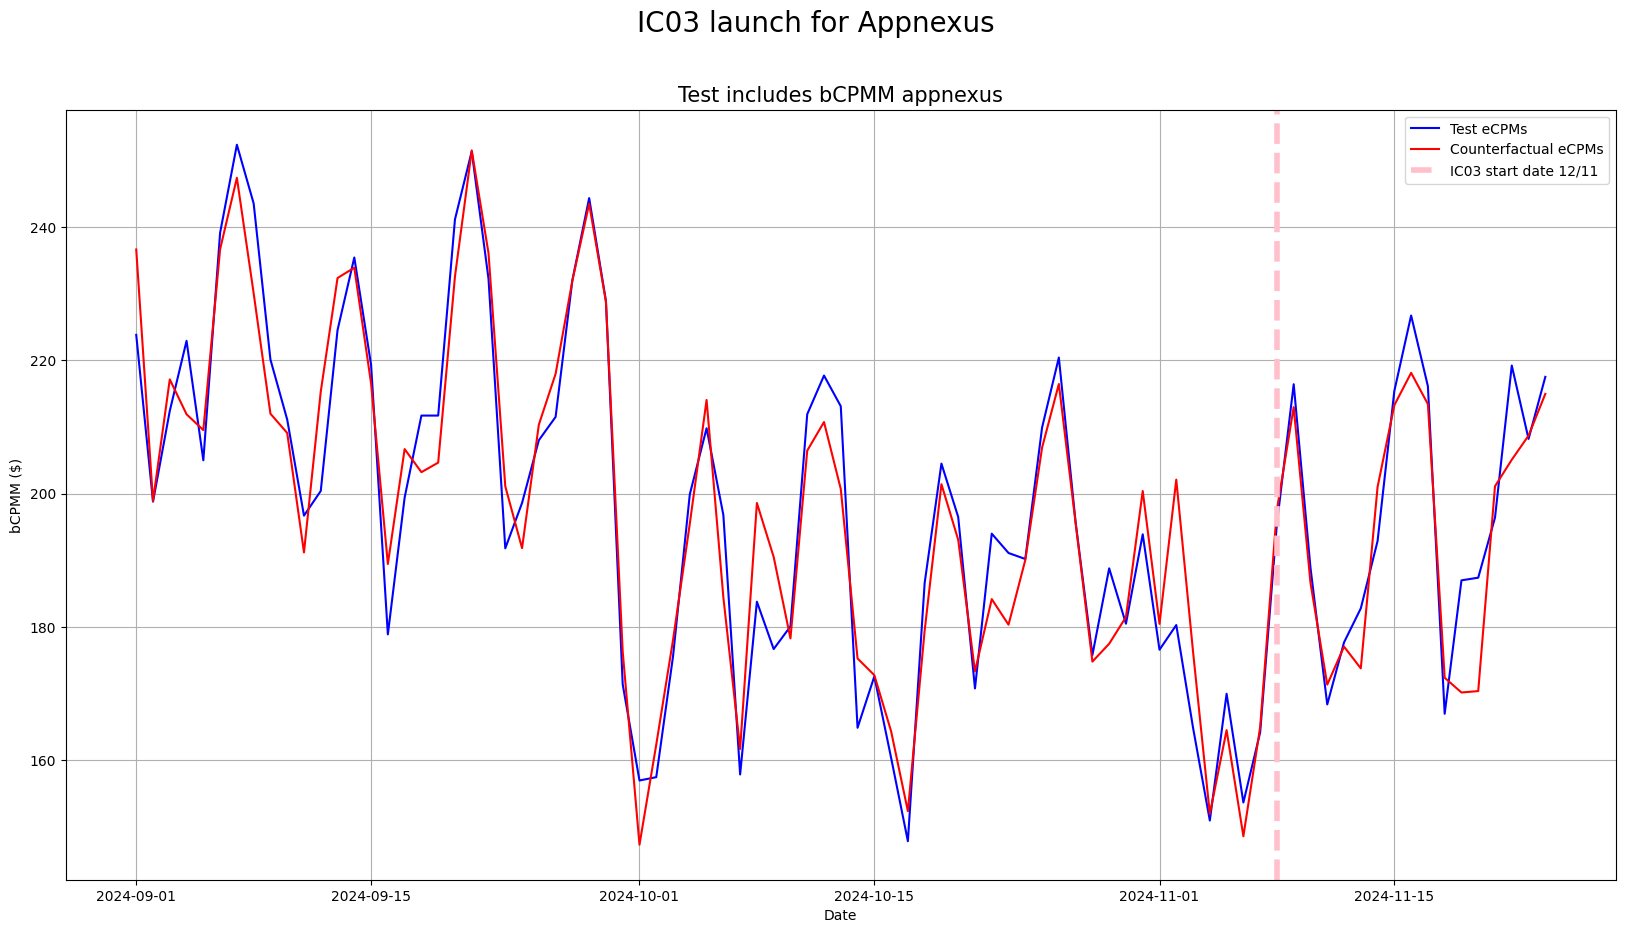

In [21]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,10))

fig.suptitle("IC03 launch for Appnexus", fontsize=20)

x = df_predictions.index

labels = ['Test eCPMs', 'Counterfactual eCPMs', 'IC03 start date 12/11']

ax.plot(x, df_predictions['Test rCPM'], color='blue')
ax.plot(x, df_predictions['Counterfactual rCPM'], color='red')
ax.axvline(dt.datetime(2024, 11, 8), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('bCPMM ($)')
ax.set_xlabel('Date')
ax.set_title('Test includes bCPMM appnexus', size=15)
ax.legend(labels, loc='best')
ax.grid(True)

In [22]:
df_predictions.tail(5)

,Test rCPM,Counterfactual rCPM
2024-11-20,187.4,170.399563
2024-11-21,196.4,201.104084
2024-11-22,219.2,205.083796
2024-11-23,208.2,208.695801
2024-11-24,217.5,214.954625


In [23]:
df_predictions.to_csv('df_predictions_ic03_appnexus_no_gmb.csv')

In [24]:
# coefficients and intercept 

cdf = pd.DataFrame(lin2.coef_, columns=['Coefficients'])

coefs = pd.DataFrame(
    lin2.coef_[1:],
    columns=["Coefficients"],
    index=X_train.columns,
)

# Rank the coefficients from highest to lowest
coefs = coefs.sort_values(by="Coefficients", ascending=False)

coefs

,Coefficients
other bCPMM,1.541912
yahoossp bCPMM,0.649048
rubicon bCPMM,0.421903
unruly bCPMM,0.402192
amx bCPMM,0.363553
ix bCPMM,0.178809
rtbhouse bCPMM,0.178772
adyoulike bCPMM,0.096699
gumgum bCPMM,0.024092
medianet bCPMM,-0.804737


In [25]:
#coefs.to_csv('coefs.csv')

In [26]:
intercept = lin2.intercept_

print("Intercept = "+"{:.4f}".format(intercept))

Intercept = 6.8877
